##  Итоговый проект 

Для исследования выбран датасет по предсказанию стоимости медицинской страховки
https://www.kaggle.com/mirichoi0218/insurance

**Информация о данных**
* **age**: возраст основного бенефициара 
* **sex**: пол страховщика, женский, мужской 
* **bmi**: индекс массы тела, обеспечивающий понимание тела, веса, который относительно высокий или низкий по отношению к росту, объективный индекс массы тела (кг / м ^ 2) с использованием отношения роста к весу, в идеале от 18,5 до 24,9 
* **children**: количество детей, охваченных медицинским страхованием / количество иждивенцев 
* **smoker**: курение 
* **region**: жилая зона получателя в США, северо-восток, юго-восток, юго-запад, северо-запад 
* **charges**: индивидуальные медицинские расходы, выставленные на счет медицинского страхования.

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [33]:
df = pd.read_csv('insurance.csv', sep=',')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [34]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [5]:
df.shape

(1338, 7)

Данные представлены как признаками числового типа, так и категориальными. Представлено 7 показателей по 1338 наблюдений.



Проведем процедуру по возможному изменению типа данных для экономии ресурсов памяти

In [35]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [36]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 76.1%


In [37]:
df.dtypes

age             int8
sex         category
bmi          float32
children        int8
smoker      category
region      category
charges      float32
dtype: object

In [9]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663391,1.094918,13270.424805
std,14.049960,6.098187,1.205493,12110.006836
min,18.000000,15.960000,0.000000,1121.873901
25%,27.000000,26.296251,0.000000,4740.287109
50%,39.000000,30.400000,1.000000,9382.032715
75%,51.000000,34.693750,2.000000,16639.912109
max,64.000000,53.130001,5.000000,63770.429688


В данных нет пропусков, среднее значение близко к медианному, минимальные и максимальные значения признаков не указывают явно на наличие выбросов и искаженных данных.

Проанализируем целевую переменную "charges".

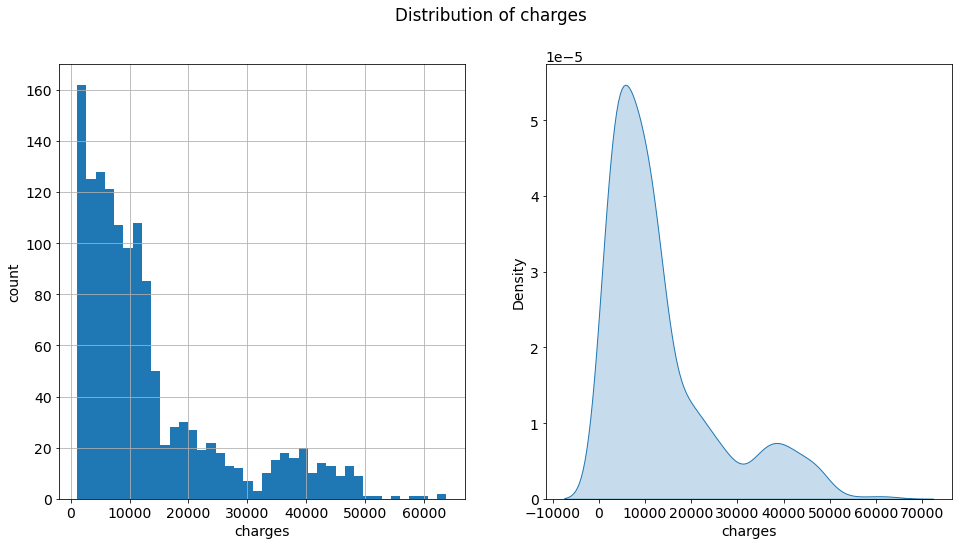

In [16]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['charges'].hist(density=False, bins=40)
plt.ylabel('count')
plt.xlabel('charges')

plt.subplot(122)
sns.kdeplot(df['charges'], shade=True, legend=False)
plt.xlabel('charges')

plt.suptitle('Distribution of charges')
plt.show()

На графиках распределения не видно явных выбросов. Значения расходов по страховке в основном находится в диапазоне до 15000. Возможно, имеет смысл разделение датасета на 3 подвыборки по стоимости: от 0 до 15000; от 15000 до 32000; дороже 32000.

In [17]:
target_mean = round(df['charges'].mean(), 2)
target_median = df['charges'].median()
target_mode = df['charges'].mode()[0]

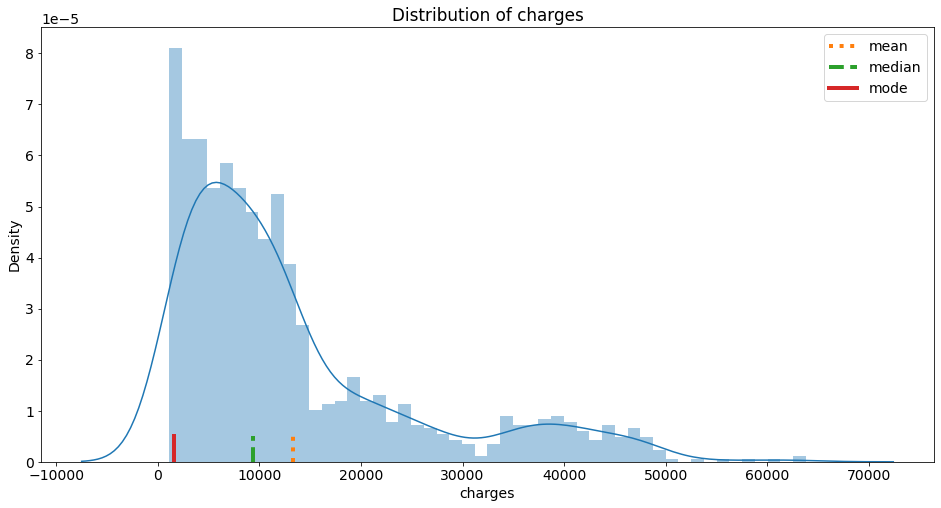

In [20]:
plt.figure(figsize = (16, 8))

sns.distplot(df['charges'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode',  linewidth=4)

plt.title('Distribution of charges')
plt.legend()
plt.show()

Проанализируем категориальные признаки и преобразуем датасет включением фиктивных переменных для этих признаков.

In [10]:
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

В датасете примерно одинаковое количество данных как о женщинах, так и о мужчинах.

In [38]:
df = pd.concat([df, pd.get_dummies(df['sex'])], axis=1)
df.head()

,age,sex,bmi,children,smoker,region,charges,female,male
0,19,female,27.900000,0,yes,southwest,16884.923828,1,0
1,18,male,33.770000,1,no,southeast,1725.552246,0,1
2,28,male,33.000000,3,no,southeast,4449.461914,0,1
3,33,male,22.705000,0,no,northwest,21984.470703,0,1
4,32,male,28.879999,0,no,northwest,3866.855225,0,1


In [12]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

Приблизительно 80% являются некурящими.

In [39]:
df = pd.concat([df, pd.get_dummies(df['smoker'])], axis=1)
df.head()

,age,sex,bmi,children,smoker,region,charges,female,male,no,yes
0,19,female,27.900000,0,yes,southwest,16884.923828,1,0,0,1
1,18,male,33.770000,1,no,southeast,1725.552246,0,1,1,0
2,28,male,33.000000,3,no,southeast,4449.461914,0,1,1,0
3,33,male,22.705000,0,no,northwest,21984.470703,0,1,1,0
4,32,male,28.879999,0,no,northwest,3866.855225,0,1,1,0


In [14]:
df['region'].value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

Количество проживающих в 4 представленных регионах также является примерно одинаковым.

In [40]:
df = pd.concat([df, pd.get_dummies(df['region'])], axis=1)
df.head()

,age,sex,bmi,children,smoker,region,charges,female,male,no,yes,northeast,northwest,southeast,southwest
0,19,female,27.900000,0,yes,southwest,16884.923828,1,0,0,1,0,0,0,1
1,18,male,33.770000,1,no,southeast,1725.552246,0,1,1,0,0,0,1,0
2,28,male,33.000000,3,no,southeast,4449.461914,0,1,1,0,0,0,1,0
3,33,male,22.705000,0,no,northwest,21984.470703,0,1,1,0,0,1,0,0
4,32,male,28.879999,0,no,northwest,3866.855225,0,1,1,0,0,1,0,0


Логический анализ взаимосвязи стоимости мед.страховки в зависимости от категориальных признаков: 
* стоимость, скорее всего, не будет зависеть от пола страхующегося;
* так как курение создает риски для здоровья, это может стать причиной увеличения стоимости, данный признак, скорее всего, будет значимым;
* район проживания скорее всего не будет оказывать влияния на стоимость, если только в каком-либо из районов нету каких-либо преференций, либо если это частные страховки, в более "зажиточных" районах их стоимость может быть выше.

Проанализируем числовые признаки.

In [24]:
df.dtypes

age              int8
sex          category
bmi           float32
children         int8
smoker       category
region       category
charges       float32
female          uint8
male            uint8
no              uint8
yes             uint8
northeast       uint8
northwest       uint8
southeast       uint8
southwest       uint8
dtype: object

In [41]:
df_num_features = df.select_dtypes(include=['float32', 'int8'])
df_num_features.drop('charges', axis=1, inplace=True)

In [26]:
df_num_features

,age,bmi,children
0,19,27.900000,0
1,18,33.770000,1
2,28,33.000000,3
3,33,22.705000,0
4,32,28.879999,0
...,...,...,...
1333,50,30.969999,3
1334,18,31.920000,0
1335,18,36.849998,0
1336,21,25.799999,0


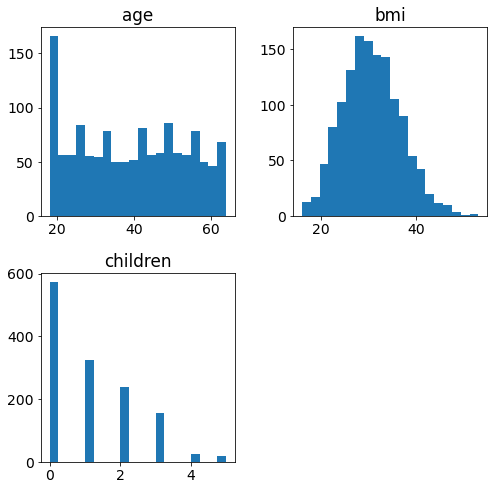

In [27]:
df_num_features.hist(figsize=(8, 8), bins=20, grid=False);

Наибольшая группа клиентов возраста около 18-19 лет, в целом распределение признака "возраст" похоже на равномерное. Распределение признака "bmi" похоже на нормальное. Сложно, не зная нюансов страхования, решить, влияет ли число детей на стоимость. Возможно, чем больше детей, тем она дороже. "bmi" может влиять на стоимость страховки: высокое значение индекса массы тела ведет к рискам со здоровьем, что может привестик ее удорожанию.

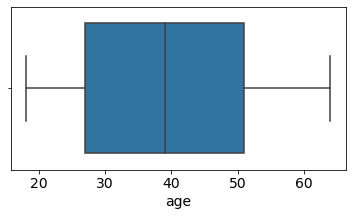

In [28]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['age'], whis=1.5)

plt.xlabel('age')
plt.show()

У признака "age" нет выбросов, нет пропусков, он не требует каких-то преобразований

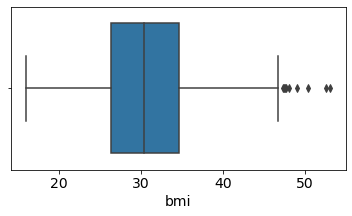

In [29]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['bmi'], whis=1.5)

plt.xlabel('bmi')
plt.show()

Похоже, что есть выбросы у признака "bmi", удалять их не будем, потому что, возможно, это не выбросы, а есть люди с избыточным весом в выборке.

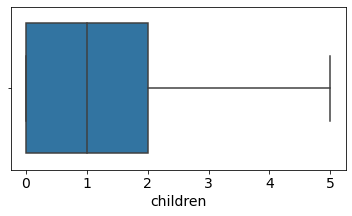

In [30]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['children'], whis=1.5)

plt.xlabel('children')
plt.show()

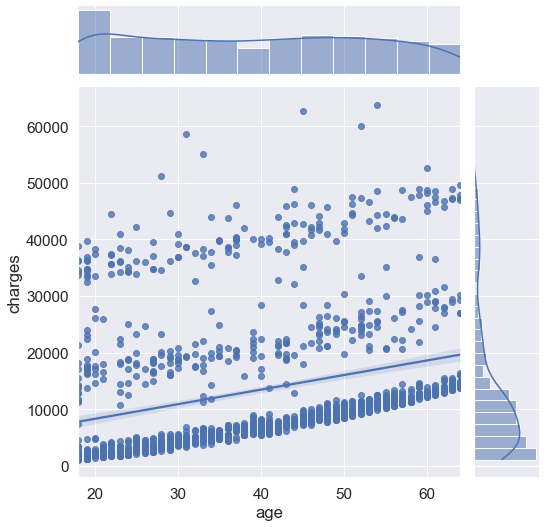

In [42]:
grid = sns.jointplot(df['age'], df['charges'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

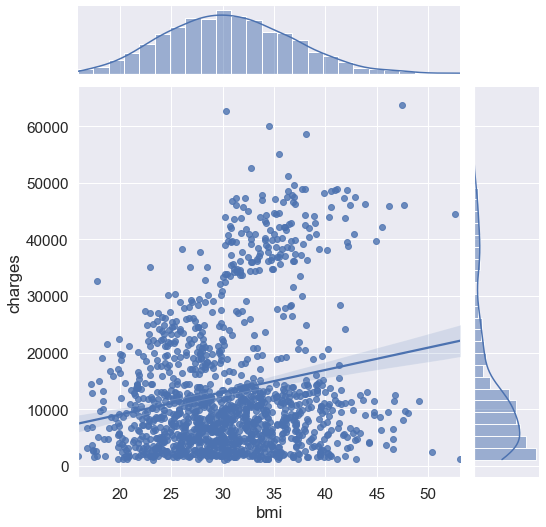

In [43]:
grid = sns.jointplot(df['bmi'], df['charges'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

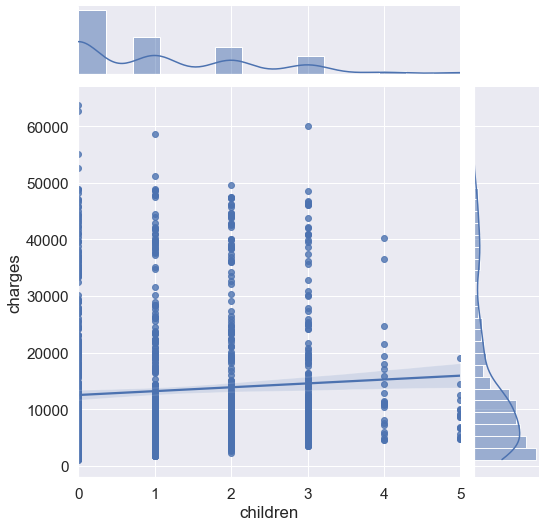

In [44]:
grid = sns.jointplot(df['children'], df['charges'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

По диаграммам видно, что связи между целевой переменной и количеством детей нет, данный признак можно исключить из рассмотрения при построении модели

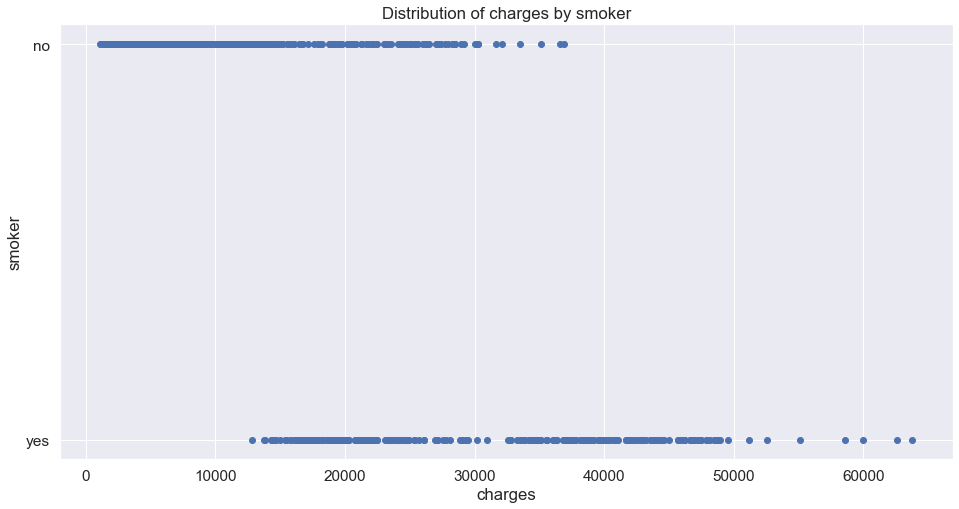

In [47]:
plt.figure(figsize=(16, 8))

plt.scatter(df['charges'], df['smoker'])

plt.xlabel('charges')
plt.ylabel('smoker')
plt.title('Distribution of charges by smoker')
plt.show()

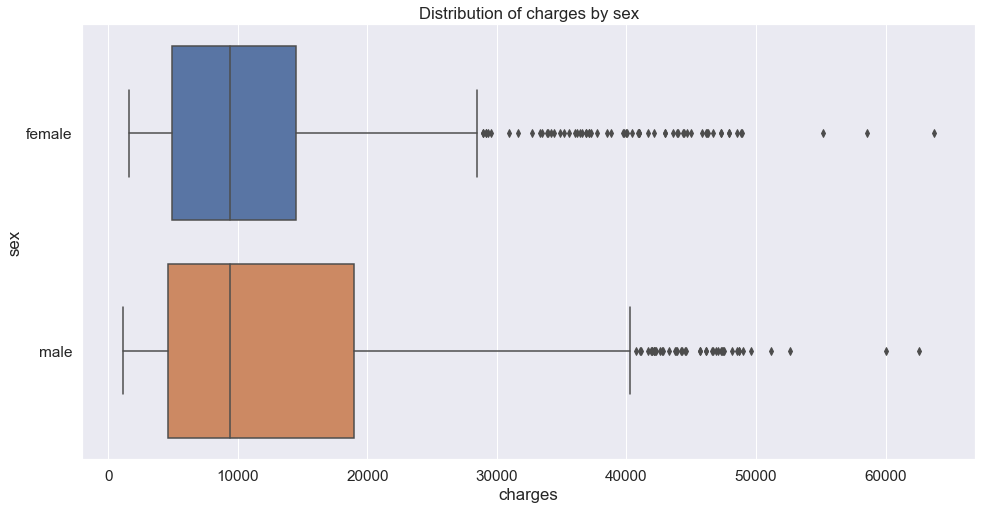

In [49]:
plt.figure(figsize=(16, 8))

sns.boxplot(df['charges'], df['sex'], whis=1.5)

plt.xlabel('charges')
plt.ylabel('sex')
plt.title('Distribution of charges by sex')
plt.show()

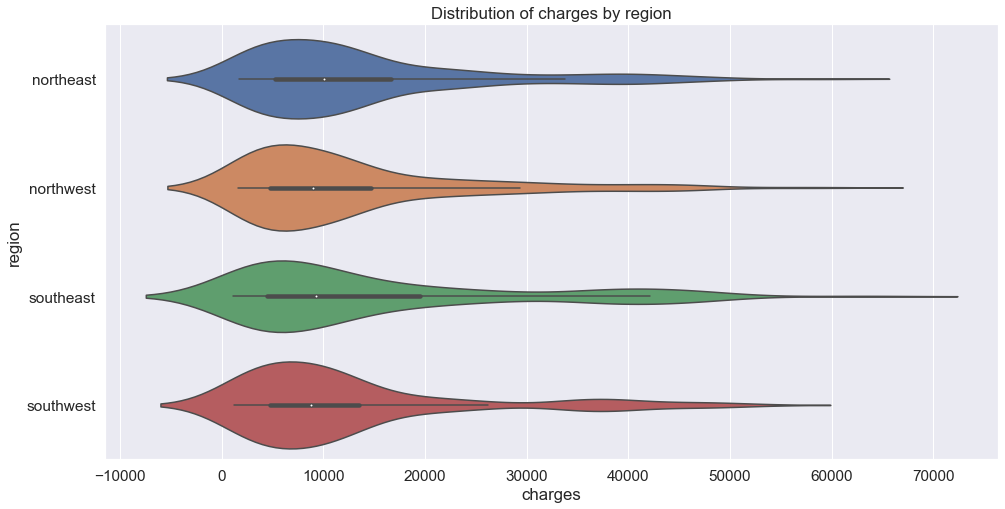

In [50]:
plt.figure(figsize=(16, 8))

sns.violinplot(df['charges'], df['region'])

plt.xlabel('charges')
plt.ylabel('region')
plt.title('Distribution of charges by region')
plt.show()

Удалим из датасета дублирующие категориальные признаки

In [71]:
df = df.drop(columns=['sex', 'smoker', 'region'])
df.head()

,age,bmi,children,charges,female,male,no,yes,northeast,northwest,southeast,southwest
0,-1.438764,-0.453320,0,16884.923828,1,0,0,1,0,0,0,1
1,-1.509965,0.509621,1,1725.552246,0,1,1,0,0,0,1,0
2,-0.797954,0.383307,3,4449.461914,0,1,1,0,0,0,1,0
3,-0.441948,-1.305531,0,21984.470703,0,1,1,0,0,1,0,0
4,-0.513149,-0.292557,0,3866.855225,0,1,1,0,0,1,0,0


Построим корреляционную матрицу

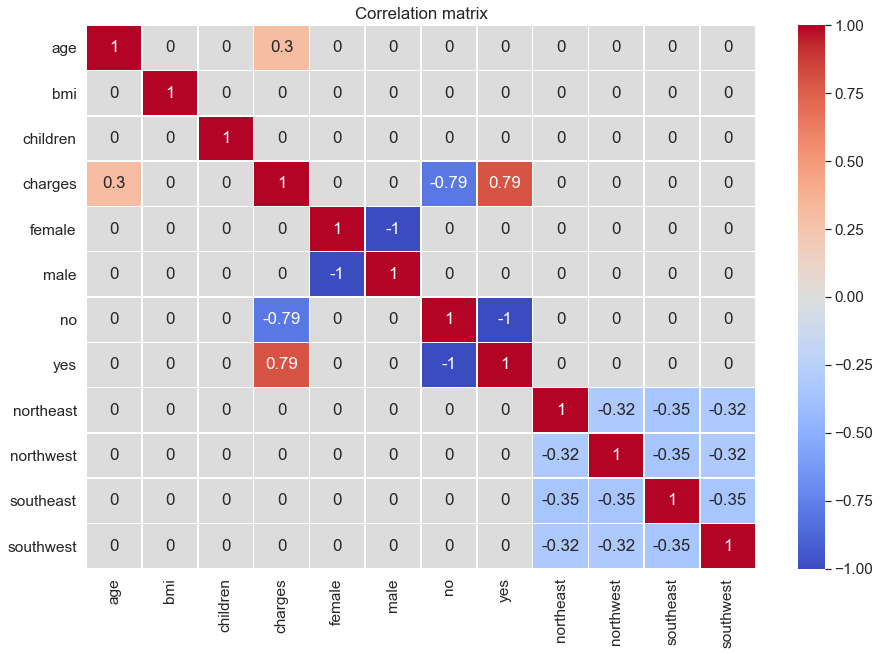

In [32]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Исходя из значений коэффициентов парной корреляции, наибольшее влияние на расходы по мед.страховке оказывает признак "smoking". Есть связь, хоть и не очень сильная, с возрастом. С остальными признаками коэффициент корреляции менее 0.3.

Были построены все виды моделей, которые были пройдены в рамках курса. Модели были оценены для всего набора признаков, также были исключены такие признаки, как "sex", "region" в силу их незначимости (по итогам предварительного анализа). Так как у dummy-переменных признака "smoking" высокая корреляция между собой, во избежание мультиколлинеарности был исключен и признак "no", как менее значимый. Исключение всех данных признаков не ухудшило качества моделей.

В качестве лучшей модели была принята модель градиентного бустинга (Gradient Boosting). Несмотря на то, что на тренировочных данных R2 ,был выше у модели Random Forest (0,913), а МАЕ=1950.505, на тестовых данных результат был хуже, чем у выбранной модели.

In [51]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [72]:
df.columns.tolist()

['age',
 'bmi',
 'children',
 'charges',
 'female',
 'male',
 'no',
 'yes',
 'northeast',
 'northwest',
 'southeast',
 'southwest']

In [73]:
feature_names = df.columns.tolist()
feature_names.remove('charges')
feature_names.remove('male')
feature_names.remove('female')
feature_names.remove('northeast')
feature_names.remove('northwest')
feature_names.remove('southeast')
feature_names.remove('southwest')
feature_names.remove('no')
feature_names.remove('children')
target_name = 'charges'

In [74]:
X = df[feature_names]
Y = df[target_name]

In [75]:
feature_names

['age', 'bmi', 'yes']

In [55]:
X.dtypes

age           int8
sex       category
bmi        float32
smoker    category
region    category
yes          uint8
dtype: object

In [76]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['float32', 'int8']).columns.tolist()
feature_names_for_stand

['age', 'bmi']

In [77]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [78]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
df.head()

,age,bmi,children,charges,female,male,no,yes,northeast,northwest,southeast,southwest
0,-1.438764,-0.453320,0,16884.923828,1,0,0,1,0,0,0,1
1,-1.509965,0.509621,1,1725.552246,0,1,1,0,0,0,1,0
2,-0.797954,0.383307,3,4449.461914,0,1,1,0,0,0,1,0
3,-0.441948,-1.305531,0,21984.470703,0,1,1,0,0,1,0,0
4,-0.513149,-0.292557,0,3866.855225,0,1,1,0,0,1,0,0


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=True, random_state=21)

In [80]:
gb_model = GradientBoostingRegressor(random_state=21)
gb_model

GradientBoostingRegressor(random_state=21)

In [81]:
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
gs.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(random_state=21), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [82]:
gs.best_params_

{'max_depth': 3, 'n_estimators': 50}

In [83]:
gs.best_score_

0.8540399333521473

In [84]:
final_model = GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=21)
final_model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=50, random_state=21)

R2:	0.895
MAE:	2168.315
MSE:	15496670.892


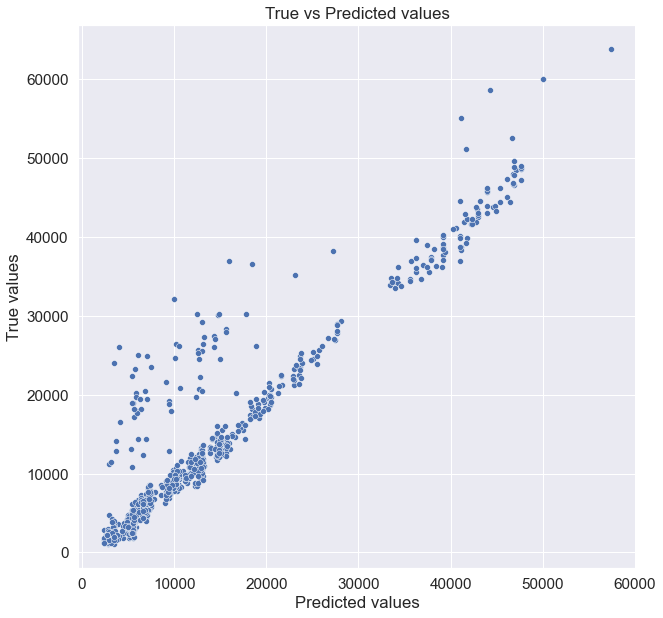

In [85]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.833
MAE:	2594.952
MSE:	24156905.178


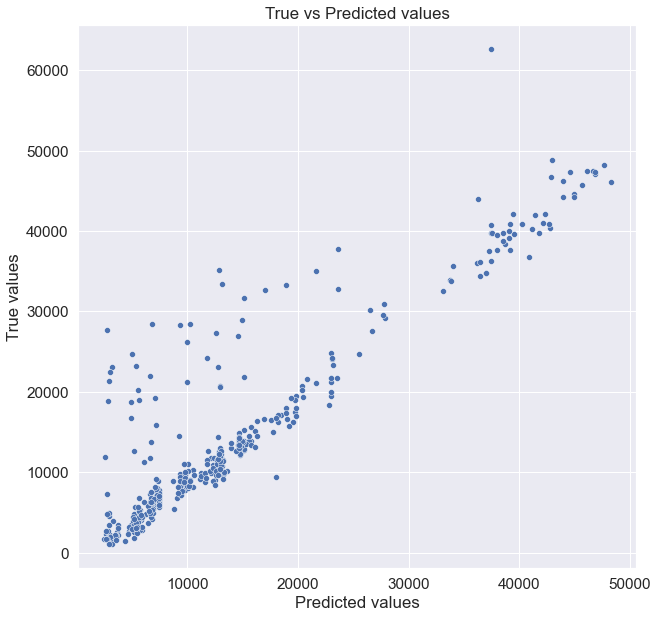

In [86]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [87]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,yes,0.698982
1,bmi,0.180073
0,age,0.120945


In [88]:
SCALER_FILE_PATH = 'scaler.pkl'
MODEL_FILE_PATH = 'model.pkl' 

In [89]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [90]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)